In [ ]:
import numpy as np
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.metrics import AUC, Precision, Recall
from sklearn.metrics import roc_curve, auc
import cv2


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

input_shape = (224, 224, 1)
batch_size = 32

In [ ]:
# folder_path =  '/content/gdrive/MyDrive/chest_xray_denoising_model_images'
folder_path = '/content/gdrive/MyDrive/Dataset'
train_images = sorted(os.listdir(folder_path))
train_image = []

In [ ]:
for im in train_images:
    img = image.load_img(folder_path +'/'+ im, target_size=(input_shape[0], input_shape[1]), color_mode='grayscale')
    img = image.img_to_array(img)
    img = img / 255
    train_image.append(img)

train_df = np.array(train_image)


In [ ]:

def add_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss * 0.05
    return noisy


In [ ]:
noised_df = []
for img in train_df:
    noisy = add_noise(img)
    noised_df.append(noisy)

noised_df = np.array(noised_df)


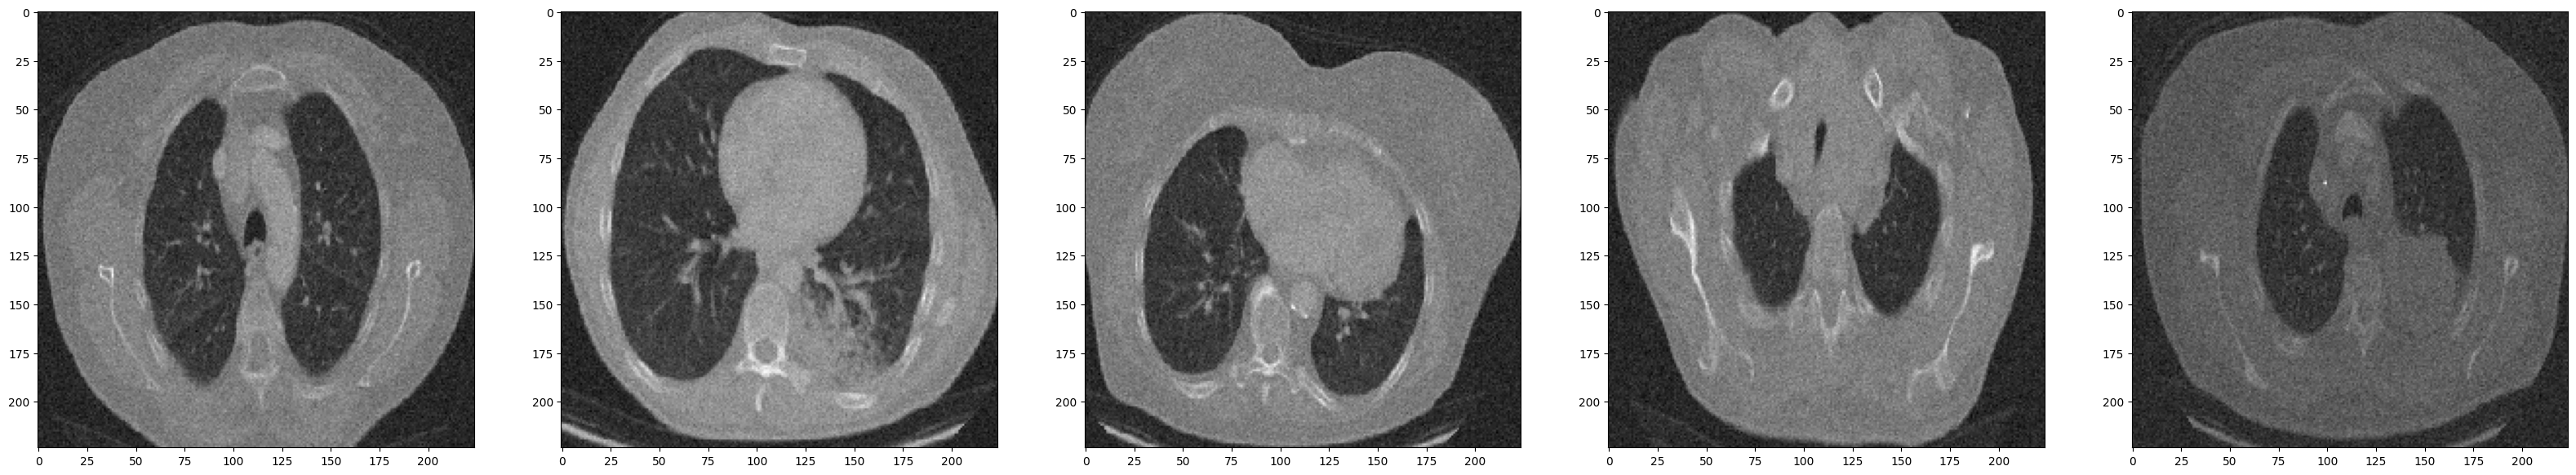

In [ ]:
def plot_img(dataset):
    f, ax = plt.subplots(1, 5)
    f.set_size_inches(40, 20)
    for i in range(5):
        ax[i].imshow(dataset[i], cmap='gray')
    plt.show()

plot_img(noised_df)


In [ ]:
xnoised = noised_df[:500]
xtest = train_df[:500]

In [ ]:

xtest_binary = (xtest > 0.5).astype(int)


In [ ]:
def unet_model(input_shape=input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    concat4 = concatenate([conv2, up4], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    concat5 = concatenate([conv1, up5], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    output = Conv2D(1, 3, activation='sigmoid', padding='same')(conv5)

    adam_optimizer = Adam(learning_rate=1e-4)

    model = Model(inputs, output)
    model.compile(optimizer=adam_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])

    return model

model = unet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

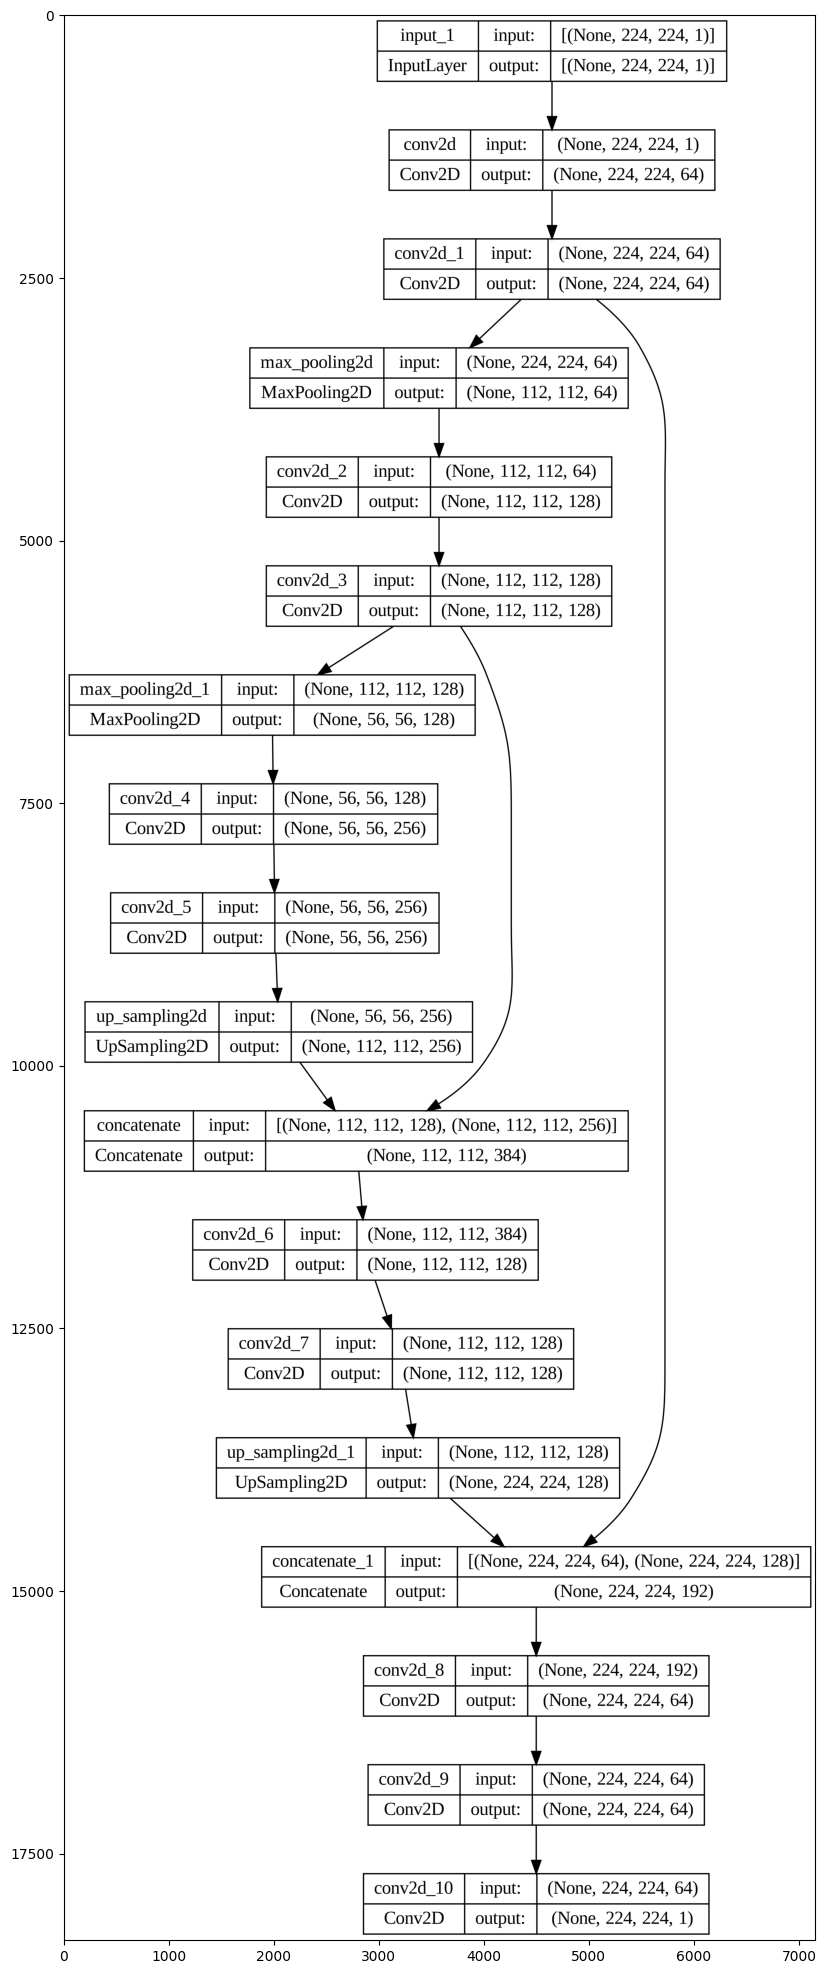

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt


plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True, dpi=900)  # Adjust dpi as needed


img = plt.imread('unet_model.png')
plt.figure(figsize=(100, 25))
plt.imshow(img)
plt.show()


In [ ]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')
    history = model.fit(xnoised, xtest, epochs=10, batch_size=batch_size,
                        validation_data=(xtest, xtest_binary), callbacks=[early_stopping])


# xtest_biary



Epoch 1/10
16/16 [==============================] - 83s 3s/step - loss: 0.6852 - accuracy: 0.0527 - precision: 0.9952 - recall: 0.8080 - auc: 0.8761 - val_loss: 0.6351 - val_accuracy: 0.7010 - val_precision: 0.6080 - val_recall: 0.9978 - val_auc: 0.9810
Epoch 2/10
16/16 [==============================] - 17s 1s/step - loss: 0.6266 - accuracy: 0.0562 - precision: 0.9999 - recall: 0.5569 - auc: 0.7867 - val_loss: 0.4225 - val_accuracy: 0.8632 - val_precision: 0.7950 - val_recall: 0.9496 - val_auc: 0.9691
Epoch 3/10
16/16 [==============================] - 18s 1s/step - loss: 0.5710 - accuracy: 0.0562 - precision: 0.9999 - recall: 0.5086 - auc: 0.9328 - val_loss: 0.4416 - val_accuracy: 0.8070 - val_precision: 0.7096 - val_recall: 0.9873 - val_auc: 0.9819
Epoch 4/10
16/16 [==============================] - 18s 1s/step - loss: 0.5608 - accuracy: 0.0562 - precision: 0.9999 - recall: 0.5001 - auc: 0.9702 - val_loss: 0.4106 - val_accuracy: 0.8369 - val_precision: 0.7430 - val_recall: 0.9904 - 

In [ ]:
files_location = "/content/gdrive/MyDrive/final_saved_models/model_25933pm"
model_json = model.to_json()
with open(files_location+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(files_location+".h5")
print("Saved model to disk")



Saved model to disk


In [ ]:
# from keras.models import model_from_json

# with open("/content/gdrive/MyDrive/savedModel_1/model_18110820.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# loaded_model = model_from_json(loaded_model_json)

# loaded_model.load_weights("/content/gdrive/MyDrive/savedModel_1/model_18110820.h5")

# print("Model has been loaded.")


In [ ]:
# loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


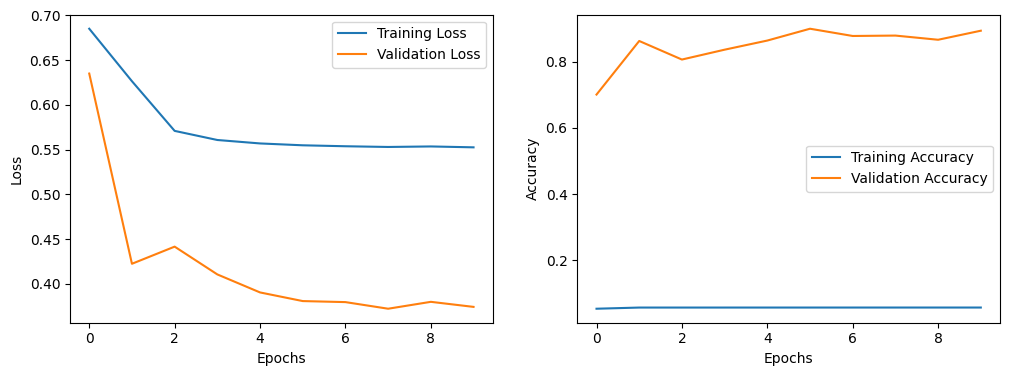

In [ ]:


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


16/16 [==============================] - 4s 275ms/step


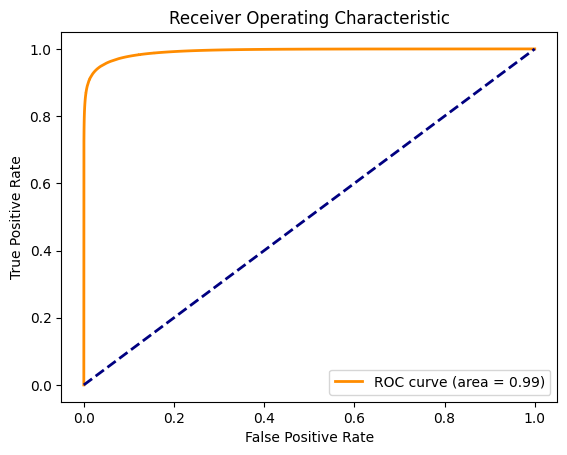

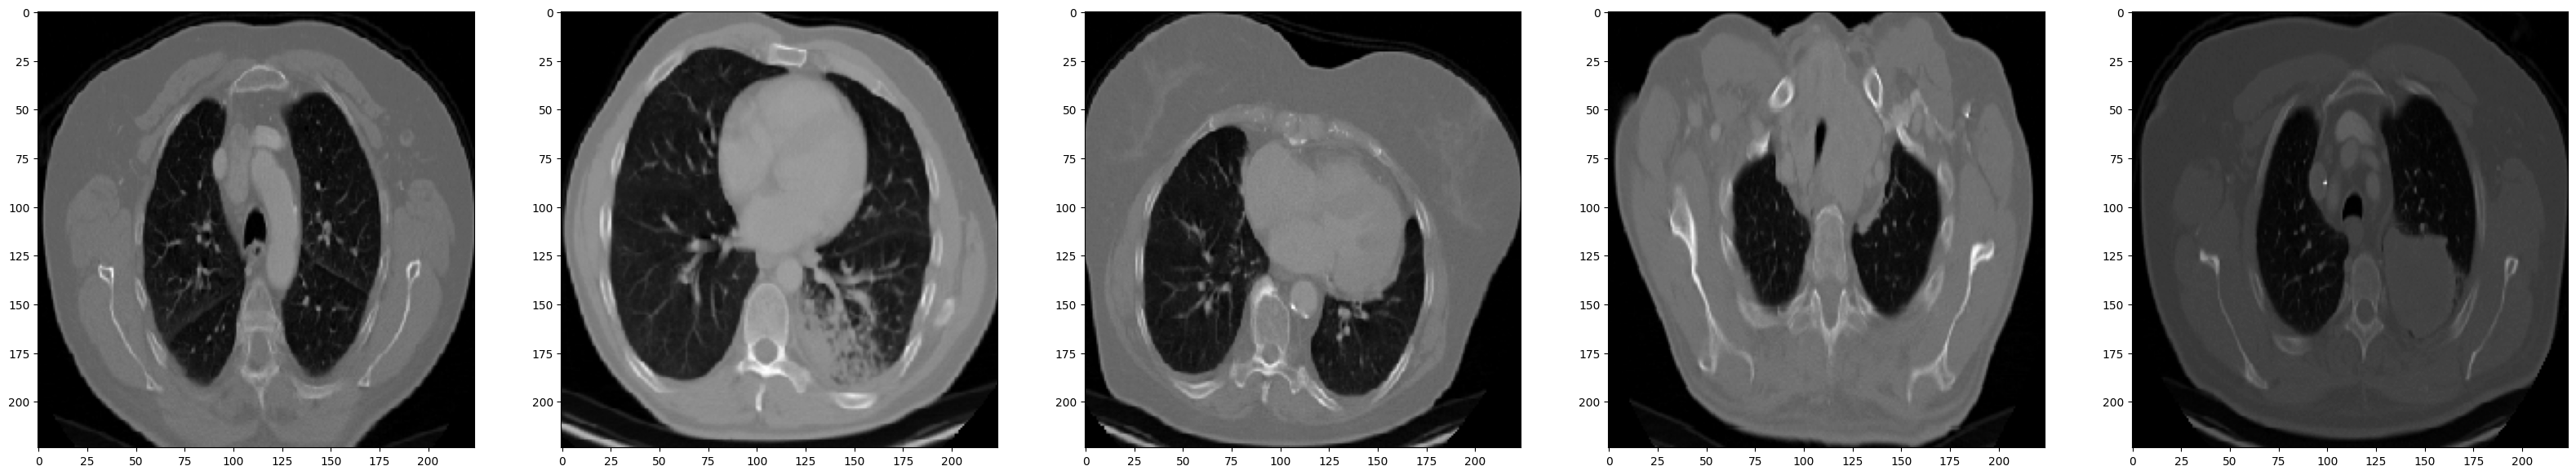

In [ ]:


y_pred = model.predict(xtest)
y_pred_binary = (y_pred > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(xtest_binary.flatten(), y_pred.flatten())
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
plot_img(train_df)


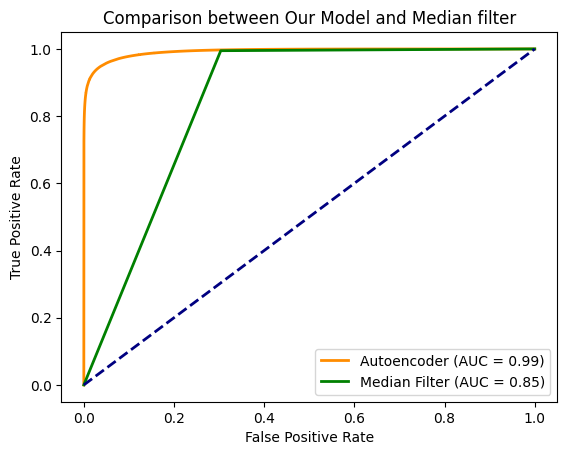

In [ ]:

median_blur_binary = (cv2.medianBlur(xtest[0], 5) > 0.4).astype(int)


fpr_median_filter, tpr_median_filter, thresholds_median_filter = roc_curve(xtest_binary[0].flatten(), median_blur_binary.flatten())
roc_auc_median_filter = auc(fpr_median_filter, tpr_median_filter)



plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Autoencoder (AUC = {roc_auc:.2f})')
plt.plot(fpr_median_filter, tpr_median_filter, color='green', lw=2, label=f'Median Filter (AUC = {roc_auc_median_filter:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison between Our Model and Median filter')
plt.legend(loc='lower right')
plt.show()




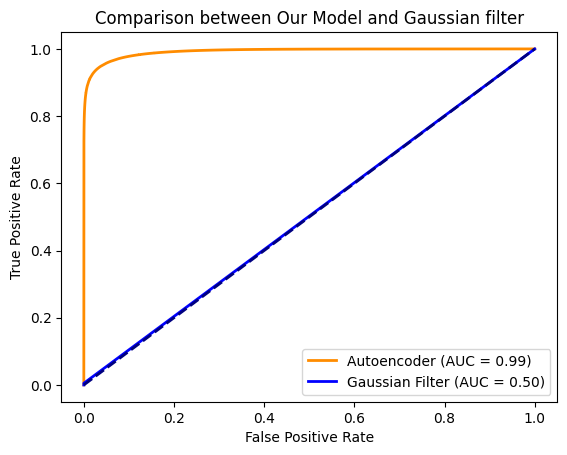

In [ ]:
gaussian_blur_binary = (cv2.GaussianBlur(xtest[0], (5, 5), 0) > 0.65).astype(int)


fpr_gaussian_filter, tpr_gaussian_filter, thresholds_gaussian_filter = roc_curve(xtest_binary[0].flatten(), gaussian_blur_binary.flatten())
roc_auc_gaussian_filter = auc(fpr_gaussian_filter, tpr_gaussian_filter)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Autoencoder (AUC = {roc_auc:.2f})')

plt.plot(fpr_gaussian_filter, tpr_gaussian_filter, color='blue', lw=2, label=f'Gaussian Filter (AUC = {roc_auc_gaussian_filter:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison between Our Model and Gaussian filter')
plt.legend(loc='lower right')
plt.show()




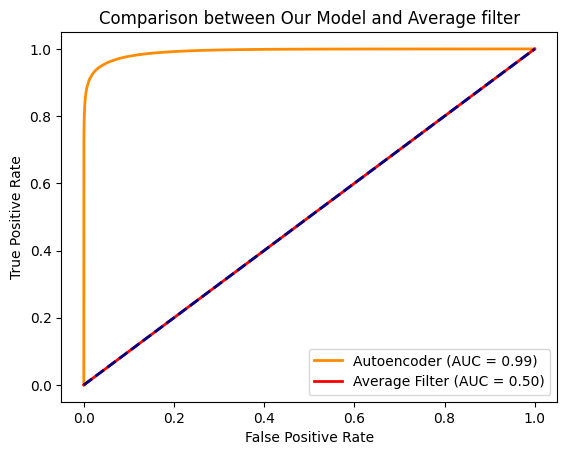

In [ ]:
average_blur_binary = (cv2.blur(xtest[0], (5, 5)) > 0.7).astype(int)



fpr_average_filter, tpr_average_filter, thresholds_average_filter = roc_curve(xtest_binary[0].flatten(), average_blur_binary.flatten())
roc_auc_average_filter = auc(fpr_average_filter, tpr_average_filter)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Autoencoder (AUC = {roc_auc:.2f})')

plt.plot(fpr_average_filter, tpr_average_filter, color='red', lw=2, label=f'Average Filter (AUC = {roc_auc_average_filter:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison between Our Model and Average filter')
plt.legend(loc='lower right')
plt.show()




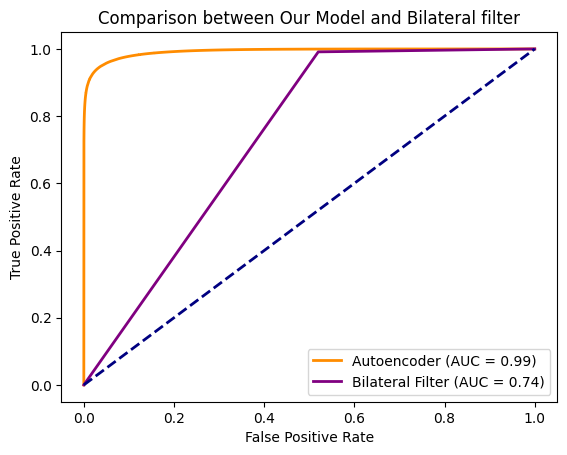

In [ ]:
bilateral_filter_binary = (cv2.bilateralFilter(xtest[0], 9, 75, 75) > 0.34).astype(int)


fpr_bilateral_filter, tpr_bilateral_filter, thresholds_bilateral_filter = roc_curve(xtest_binary[0].flatten(), bilateral_filter_binary.flatten())
roc_auc_bilateral_filter = auc(fpr_bilateral_filter, tpr_bilateral_filter)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Autoencoder (AUC = {roc_auc:.2f})')
plt.plot(fpr_bilateral_filter, tpr_bilateral_filter, color='purple', lw=2, label=f'Bilateral Filter (AUC = {roc_auc_bilateral_filter:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison between Our Model and Bilateral filter')
plt.legend(loc='lower right')
plt.show()


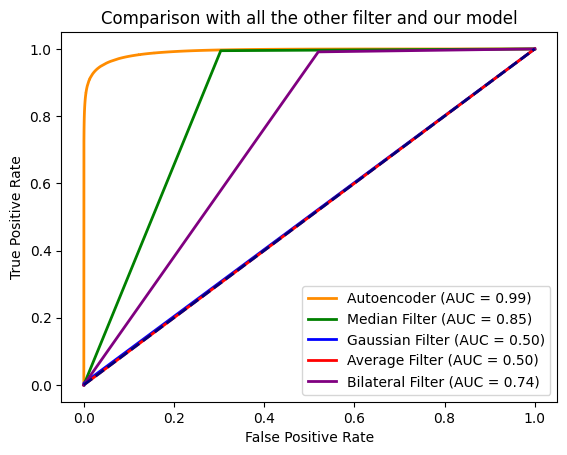

In [ ]:

median_blur_binary = (cv2.medianBlur(xtest[0], 5) > 0.4).astype(int)
gaussian_blur_binary = (cv2.GaussianBlur(xtest[0], (5, 5), 0) > 0.65).astype(int)
average_blur_binary = (cv2.blur(xtest[0], (5, 5)) > 0.7).astype(int)
bilateral_filter_binary = (cv2.bilateralFilter(xtest[0], 9, 75, 75) > 0.34).astype(int)


fpr_median_filter, tpr_median_filter, thresholds_median_filter = roc_curve(xtest_binary[0].flatten(), median_blur_binary.flatten())
roc_auc_median_filter = auc(fpr_median_filter, tpr_median_filter)



fpr_gaussian_filter, tpr_gaussian_filter, thresholds_gaussian_filter = roc_curve(xtest_binary[0].flatten(), gaussian_blur_binary.flatten())
roc_auc_gaussian_filter = auc(fpr_gaussian_filter, tpr_gaussian_filter)


fpr_average_filter, tpr_average_filter, thresholds_average_filter = roc_curve(xtest_binary[0].flatten(), average_blur_binary.flatten())
roc_auc_average_filter = auc(fpr_average_filter, tpr_average_filter)


fpr_bilateral_filter, tpr_bilateral_filter, thresholds_bilateral_filter = roc_curve(xtest_binary[0].flatten(), bilateral_filter_binary.flatten())
roc_auc_bilateral_filter = auc(fpr_bilateral_filter, tpr_bilateral_filter)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Autoencoder (AUC = {roc_auc:.2f})')
plt.plot(fpr_median_filter, tpr_median_filter, color='green', lw=2, label=f'Median Filter (AUC = {roc_auc_median_filter:.2f})')
plt.plot(fpr_gaussian_filter, tpr_gaussian_filter, color='blue', lw=2, label=f'Gaussian Filter (AUC = {roc_auc_gaussian_filter:.2f})')
plt.plot(fpr_average_filter, tpr_average_filter, color='red', lw=2, label=f'Average Filter (AUC = {roc_auc_average_filter:.2f})')
plt.plot(fpr_bilateral_filter, tpr_bilateral_filter, color='purple', lw=2, label=f'Bilateral Filter (AUC = {roc_auc_bilateral_filter:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison with all the other filter and our model')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from prettytable import PrettyTable
from math import log10,sqrt
from sklearn.metrics import f1_score
from keras.losses import binary_crossentropy
from keras import backend as K

y_pred = model.predict(xtest)

y_pred_binary = (y_pred > 0.5).astype(int)


loss, accuracy, precision, recall, areaUnderCurve = model.evaluate(xtest, xtest_binary)

f1 = f1_score(xtest_binary.flatten(), y_pred_binary.flatten())
cross_entropy = binary_crossentropy(xtest_binary.flatten(), y_pred.flatten())
cross_entropy_value = K.eval(cross_entropy)


table = PrettyTable(["Metric", "Value"])

table.add_row(["Loss", f"{loss:.4f}"])
table.add_row(["Accuracy", f"{accuracy * 100:.2f}%"])
table.add_row(["Precision", f"{precision * 100:.2f}%"])
table.add_row(["Recall", f"{recall * 100:.2f}%"])
table.add_row(["AUC", f"{areaUnderCurve * 100:.2f}%"])
table.add_row(["f1 score", f"{f1 * 100:.2f}%"])
table.add_row(["cross entropy", f"{cross_entropy_value:.2f}"])


print(table)


16/16 [==============================] - 4s 261ms/step - loss: 0.3743 - accuracy: 0.8943 - precision: 0.8188 - recall: 0.9912 - auc: 0.9923
+---------------+--------+
|     Metric    | Value  |
+---------------+--------+
|      Loss     | 0.3743 |
|    Accuracy   | 89.43% |
|   Precision   | 81.88% |
|     Recall    | 99.12% |
|      AUC      | 99.23% |
|    f1 score   | 89.68% |
| cross entropy |  0.37  |
+---------------+--------+


In [ ]:

from math import log10, sqrt
median_blur = cv2.medianBlur(xtest[0], (5))
gaussian_blur = cv2.GaussianBlur(xtest[0], (5, 5), 0)
average_blur = cv2.blur(xtest[0], (5, 5))
bilateral_filter = cv2.bilateralFilter(xtest[0], 9, 75, 75)


def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

value_median_filter = PSNR(xtest[0], median_blur)
value_gaussian_filter = PSNR(xtest[0], gaussian_blur)
value_average_filter = PSNR(xtest[0], average_blur)
value_bilateral_filter = PSNR(xtest[0], bilateral_filter)
value_autoencoder_without_filter = PSNR(xtest[0], y_pred[0])

print("\nPSNR values:")
print(f"Median Filter Image : {value_median_filter} dB")
print(f"Gaussian Filter Image : {value_gaussian_filter} dB")
print(f"Average Filter Image : {value_average_filter} dB")
print(f"Bilateral Filter Image : {value_bilateral_filter} dB")
print(f"Auto-Encoder without filter Image : {value_autoencoder_without_filter} dB")



PSNR values:
Median Filter Image : 59.97159452875096 dB
Gaussian Filter Image : 60.03968787695968 dB
Average Filter Image : 60.10924604575103 dB
Bilateral Filter Image : 60.19752339893181 dB
Auto-Encoder without filter Image : 70.67521680378428 dB


In [ ]:
from sklearn.metrics import f1_score
from keras.losses import binary_crossentropy
import keras.backend as K
from prettytable import PrettyTable
from math import log10, sqrt
from sklearn.metrics import accuracy_score, precision_score, recall_score




median_blur = cv2.medianBlur(xtest[0], (5))
median_blur_binary = (median_blur > 0.5).astype(int)
y_pred_median_filter = cv2.medianBlur(y_pred[2], (5))
y_pred_binary_median_filter = (y_pred_median_filter > 0.5).astype(int)
f1_median_filter = f1_score(xtest_binary[2].flatten(), median_blur_binary.flatten())
cross_entropy_median_filter = binary_crossentropy(xtest_binary[2].flatten(), y_pred_median_filter.flatten())
cross_entropy_value_median_filter = K.eval(cross_entropy_median_filter)


accuracy_median_filter = accuracy_score(xtest_binary[2].flatten(), median_blur_binary.flatten())
precision_median_filter = precision_score(xtest_binary[2].flatten(), median_blur_binary.flatten())
recall_median_filter = recall_score(xtest_binary[2].flatten(), median_blur_binary.flatten())

table_median_filter = PrettyTable(["Metric", "Value"])
table_median_filter.add_row(["Accuracy", f"{accuracy_median_filter * 100:.2f}%"])
table_median_filter.add_row(["Precision", f"{precision_median_filter * 100:.2f}%"])
table_median_filter.add_row(["Recall", f"{recall_median_filter * 100:.2f}%"])
table_median_filter.add_row(["F1 Score", f"{f1_median_filter * 100:.2f}%"])
table_median_filter.add_row(["Cross Entropy", f"{cross_entropy_value_median_filter:.2f}"])


print("\nMedian Filter:")
print(table_median_filter)




Median Filter:
+---------------+--------+
|     Metric    | Value  |
+---------------+--------+
|    Accuracy   | 87.37% |
|   Precision   | 48.50% |
|     Recall    | 16.75% |
|    F1 Score   | 24.91% |
| Cross Entropy |  0.45  |
+---------------+--------+


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.losses import binary_crossentropy
from prettytable import PrettyTable
from math import log10, sqrt



def calculate_metrics(original, filtered, y_pred_filtered):
    binary_filtered = (filtered > 0.5).astype(int)
    y_pred_binary_filtered = (y_pred_filtered > 0.5).astype(int)

    f1 = f1_score(original.flatten(), binary_filtered.flatten())
    cross_entropy = binary_crossentropy(original.flatten(), y_pred_filtered.flatten())
    cross_entropy_value = K.eval(cross_entropy)

    accuracy = accuracy_score(original.flatten(), binary_filtered.flatten())
    precision = precision_score(original.flatten(), binary_filtered.flatten())
    recall = recall_score(original.flatten(), binary_filtered.flatten())

    return accuracy, precision, recall, f1, cross_entropy_value


gaussian_blur = cv2.GaussianBlur(xtest[0], (5, 5), 0)
y_pred_gaussian_filter = cv2.GaussianBlur(y_pred[2], (5, 5), 0)
accuracy_gaussian_filter, precision_gaussian_filter, recall_gaussian_filter, f1_gaussian_filter, cross_entropy_value_gaussian_filter = calculate_metrics(xtest_binary[2], gaussian_blur, y_pred_gaussian_filter)


average_blur = cv2.blur(xtest[0], (5, 5))
y_pred_average_filter = cv2.blur(y_pred[2], (5, 5))
accuracy_average_filter, precision_average_filter, recall_average_filter, f1_average_filter, cross_entropy_value_average_filter = calculate_metrics(xtest_binary[2], average_blur, y_pred_average_filter)


bilateral_filter = cv2.bilateralFilter(xtest[0], 9, 75, 75)
y_pred_bilateral_filter = cv2.bilateralFilter(y_pred[2], 9, 75, 75)
accuracy_bilateral_filter, precision_bilateral_filter, recall_bilateral_filter, f1_bilateral_filter, cross_entropy_value_bilateral_filter = calculate_metrics(xtest_binary[2], bilateral_filter, y_pred_bilateral_filter)


table_gaussian_filter = PrettyTable(["Metric", "Value"])
table_gaussian_filter.add_row(["Accuracy", f"{accuracy_gaussian_filter * 100:.2f}%"])
table_gaussian_filter.add_row(["Precision", f"{precision_gaussian_filter * 100:.2f}%"])
table_gaussian_filter.add_row(["Recall", f"{recall_gaussian_filter * 100:.2f}%"])
table_gaussian_filter.add_row(["F1 Score", f"{f1_gaussian_filter * 100:.2f}%"])
table_gaussian_filter.add_row(["Cross Entropy", f"{cross_entropy_value_gaussian_filter:.2f}"])



table_average_filter = PrettyTable(["Metric", "Value"])
table_average_filter.add_row(["Accuracy", f"{accuracy_average_filter * 100:.2f}%"])
table_average_filter.add_row(["Precision", f"{precision_average_filter * 100:.2f}%"])
table_average_filter.add_row(["Recall", f"{recall_average_filter * 100:.2f}%"])
table_average_filter.add_row(["F1 Score", f"{f1_average_filter * 100:.2f}%"])
table_average_filter.add_row(["Cross Entropy", f"{cross_entropy_value_average_filter:.2f}"])



table_bilateral_filter = PrettyTable(["Metric", "Value"])
table_bilateral_filter.add_row(["Accuracy", f"{accuracy_bilateral_filter * 100:.2f}%"])
table_bilateral_filter.add_row(["Precision", f"{precision_bilateral_filter * 100:.2f}%"])
table_bilateral_filter.add_row(["Recall", f"{recall_bilateral_filter * 100:.2f}%"])
table_bilateral_filter.add_row(["F1 Score", f"{f1_bilateral_filter * 100:.2f}%"])
table_bilateral_filter.add_row(["Cross Entropy", f"{cross_entropy_value_bilateral_filter:.2f}"])



print("\nGaussian Filter:")
print(table_gaussian_filter)

print("\nAverage Filter:")
print(table_average_filter)

print("\nBilateral Filter:")
print(table_bilateral_filter)



Gaussian Filter:
+---------------+--------+
|     Metric    | Value  |
+---------------+--------+
|    Accuracy   | 86.44% |
|   Precision   | 40.18% |
|     Recall    | 17.25% |
|    F1 Score   | 24.14% |
| Cross Entropy |  0.45  |
+---------------+--------+

Average Filter:
+---------------+--------+
|     Metric    | Value  |
+---------------+--------+
|    Accuracy   | 86.58% |
|   Precision   | 40.59% |
|     Recall    | 15.85% |
|    F1 Score   | 22.79% |
| Cross Entropy |  0.45  |
+---------------+--------+

Bilateral Filter:
+---------------+--------+
|     Metric    | Value  |
+---------------+--------+
|    Accuracy   | 86.86% |
|   Precision   | 42.13% |
|     Recall    | 13.61% |
|    F1 Score   | 20.58% |
| Cross Entropy |  0.46  |
+---------------+--------+
